# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

measurement_angle_step = 0.5
angle_all = np.arange(-90, 90, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 90, -90))
    ax0.set_yticks(np.arange(-90, 91, 30))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

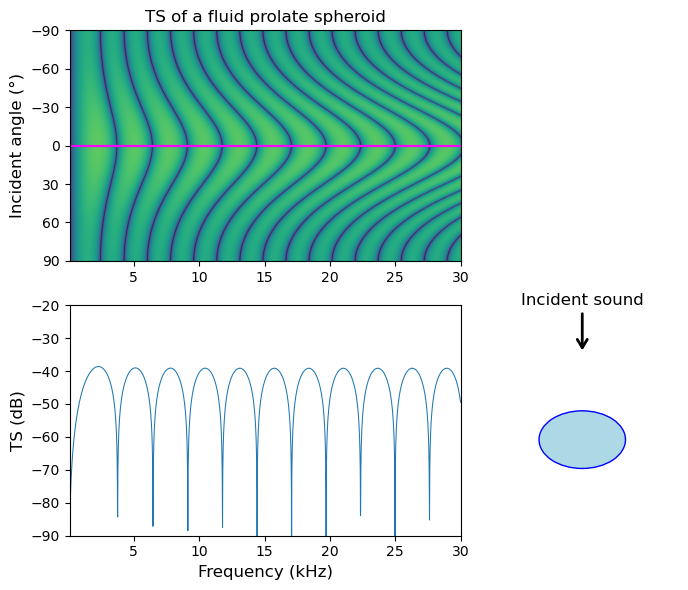

In [5]:
target1_AR = 1.5
TS_all_target1 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target1_AR)

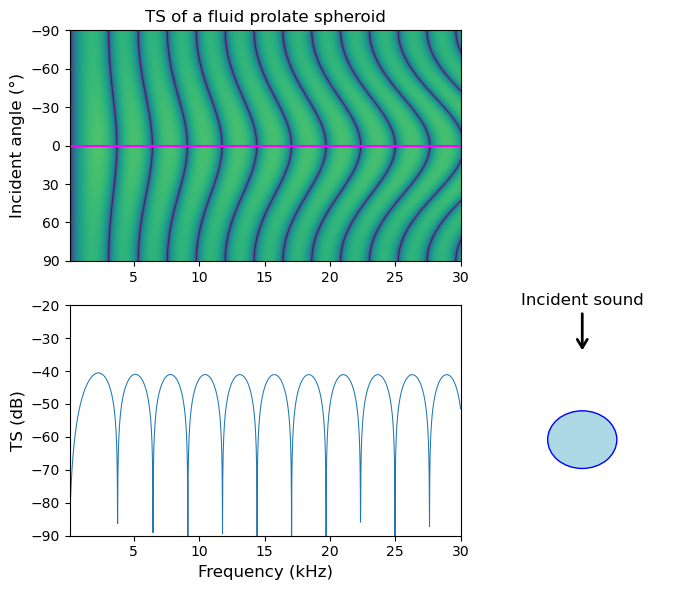

In [6]:
target2_AR = 1.2
TS_all_target2 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target2_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

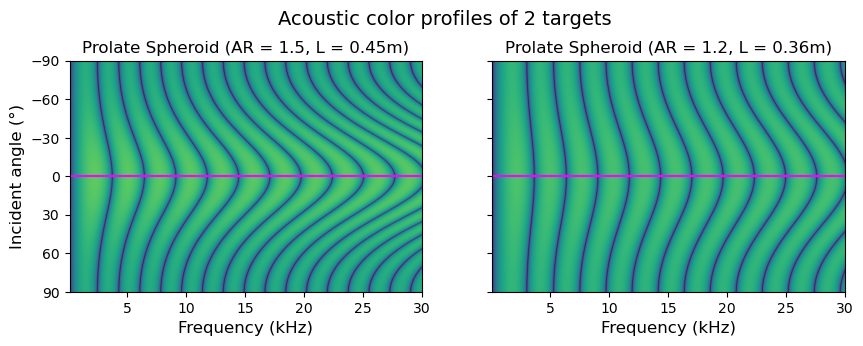

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle('Acoustic color profiles of 2 targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

ax0 = ax[0]
ax0.set_title(f'Prolate Spheroid (AR = {target1_AR:.1f}, L = {target1_AR*2*a:.2f}m)')
ax0.imshow(TS_all_target1 , aspect="auto", vmax=-25, vmin=-80,
            extent=(0, freq_upperbound//1e3, 90, -90))
ax0.set_yticks(np.arange(-90, 91, 30))
ax0.set_ylabel("Incident angle (°)", fontsize=12)
ax0.axhline(0, color="magenta")
ax0.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax0.set_xlabel("Frequency (kHz)", fontsize=12)

ax1 = ax[1]
ax1.set_title(f'Prolate Spheroid (AR = {target2_AR:.1f}, L = {target2_AR*2*a:.2f}m)')
ax1.imshow(TS_all_target2 , aspect="auto", vmax=-25, vmin=-80,
            extent=(0, freq_upperbound//1e3, 90, -90))
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.axhline(0, color="magenta")
ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax1.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


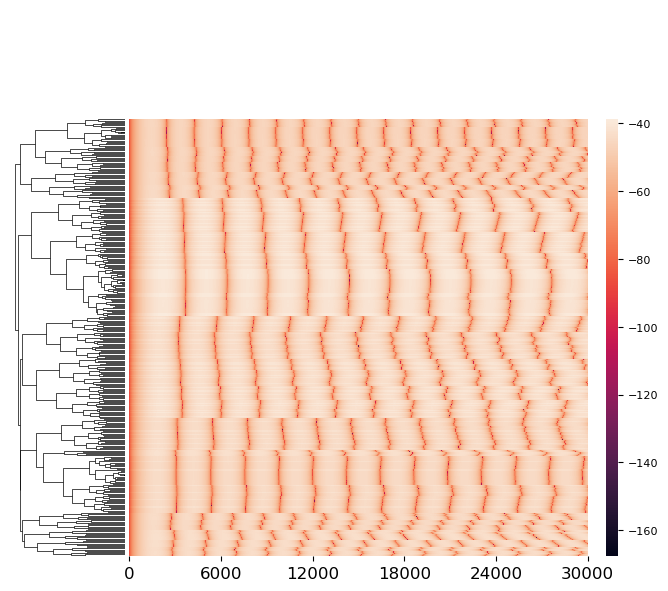

In [9]:
# Perform k-means clustering
all_waveforms_collection = np.vstack([TS_all_target1, TS_all_target2])

k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

In [10]:
def sample_angle_and_compare_response(angle):
    angle_idx = np.where(angle_all==angle)[0][0]
    TS_target1 = TS_all_target1[angle_idx,:]
    TS_target2 = TS_all_target2[angle_idx,:]

    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.plot(freq/1e3, TS_target1, lw=0.75)
    ax.plot(freq/1e3, TS_target2, lw=0.75)
    ax.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax.set_ylim(-90, -20)
    ax.grid(which='both')
    ax.set_xlabel("Frequency (kHz)", fontsize=12)
    ax.set_ylabel("TS (dB)", fontsize=12)


In [11]:
state_angle_step = 5

In [12]:
kmean_TS_codebook.labels_

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28,  9,  9,  9,  9,  9,  9,  9,
        9, 31, 31, 31, 31, 31, 31, 31,  6,  6,  6,  6,  6,  6, 25, 25, 25,
       25, 25, 25, 25, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 26,
       26, 26, 26, 26, 26,  8,  8,  8,  8,  8,  8, 21, 21, 21, 21, 32, 32,
       32, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 16, 16, 16, 16, 16,
       29, 29, 29, 29, 18, 18, 18,  0, 24, 24, 24, 20, 20,  2,  2,  2, 13,
       13, 13, 13, 17, 17, 17, 35, 35,  4,  4,  4, 22, 22, 22, 33, 33, 33,
       27, 27, 27,  3,  3, 23, 23, 23, 23, 11, 11, 11, 11, 19, 19, 19, 19,
       19, 15, 15, 15, 15,  1,  1,  1,  1, 30, 30, 30, 30, 30,  7,  7,  7,
        7,  7,  7, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34,  7,  7,  7,  7,  7,  7, 30, 30, 30, 30, 30,  1,  1,  1,  1, 15,
       15, 15, 15, 19, 19, 19, 19, 19, 11, 11, 11, 11, 23, 23, 23, 23,  3,
        3, 27, 27, 27, 33

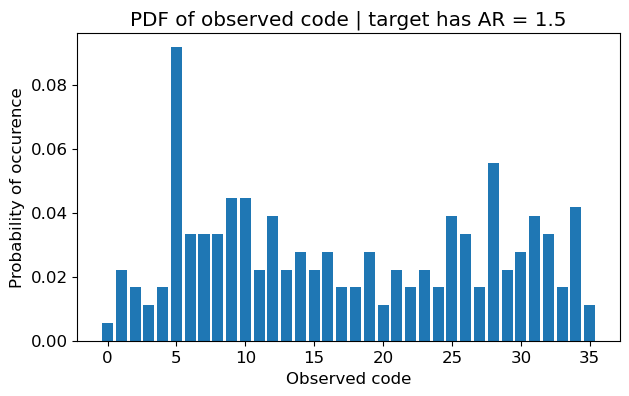

In [14]:
target1_cluster_preds = kmean_TS_codebook.predict(TS_all_target1)
density, clusters = np.histogram(target1_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

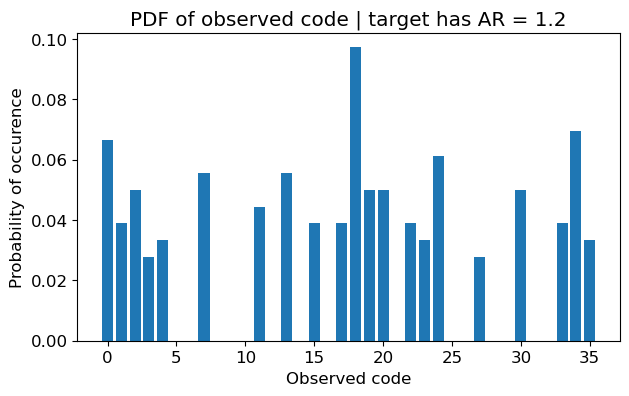

In [15]:
sphere_cluster_preds = kmean_TS_codebook.predict(TS_all_target2)
density, clusters = np.histogram(sphere_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | target has AR = {target2_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

In [16]:
state_centers = np.arange(-90, 90, state_angle_step) + 2.5
state_centers

array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
       -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
         2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5])

In [17]:
state_center = state_centers[0]
state_center

np.float64(-87.5)

In [18]:
angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
angle_indices_for_state

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [19]:
angle_all[angle_indices_for_state]

array([-90. , -89.5, -89. , -88.5, -88. , -87.5, -87. , -86.5, -86. ,
       -85.5])

In [20]:
TS_state_target1 = TS_all_target1[angle_indices_for_state]
TS_state_target1

array([[-85.66255393, -84.01269737, -82.5075643 , ..., -46.5033265 ,
        -46.54621923, -46.5921204 ],
       [-85.66255275, -84.01269595, -82.50756261, ..., -46.50034043,
        -46.54304252, -46.58875098],
       [-85.66254922, -84.01269167, -82.50755751, ..., -46.49145448,
        -46.53358543, -46.57871659],
       ...,
       [-85.66249625, -84.01262757, -82.50748121, ..., -46.37103043,
        -46.40472582, -46.44133925],
       [-85.66247862, -84.01260623, -82.50745581, ..., -46.33618155,
        -46.3671144 , -46.40094196],
       [-85.66245866, -84.01258207, -82.50742706, ..., -46.29983983,
        -46.32766774, -46.35836623]], shape=(10, 2990))

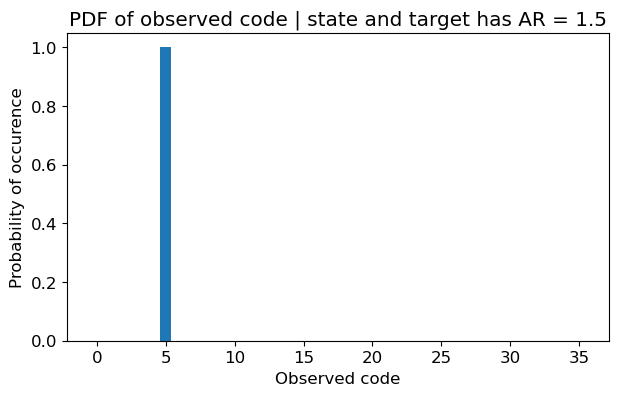

In [22]:
target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)
density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | state and target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

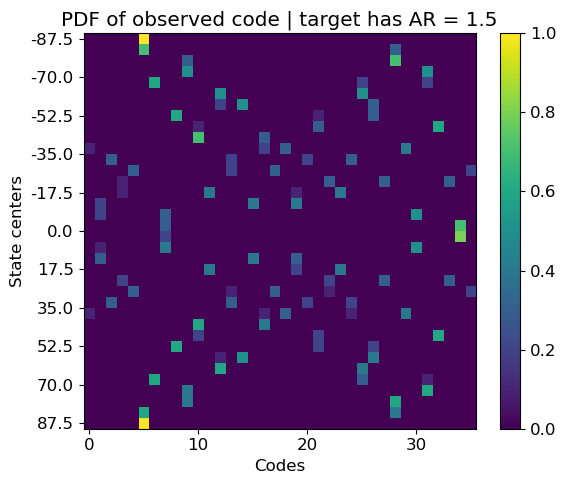

In [23]:
emission_matrix_B_target1 = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))
for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
    TS_state_target1 = TS_all_target1[angle_indices_for_state]
    target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)

    density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B_target1[i, :] = density

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(emission_matrix_B_target1, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of observed code | target has AR = {target1_AR}')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
ax.set_yticklabels(np.linspace(-90, 85, 11)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

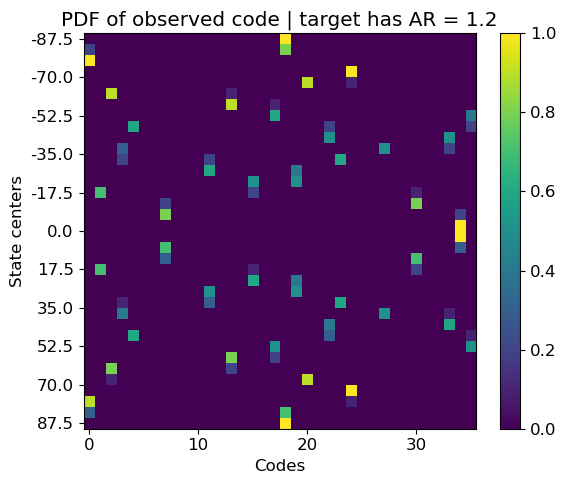

In [24]:
emission_matrix_B_target2 = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))
for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
    TS_state_target2 = TS_all_target2[angle_indices_for_state]
    target2_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target2)

    density, clusters = np.histogram(target2_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B_target2[i, :] = density

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(emission_matrix_B_target2, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of observed code | target has AR = {target2_AR}')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
ax.set_yticklabels(np.linspace(-90, 85, 11)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

In [25]:
state_centers

array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
       -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
         2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5])

In [26]:
def w_(theta):
    sigma_i = state_angle_step
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    distances = np.abs(state_centers[:, np.newaxis] - state_centers[np.newaxis, :])

    return w_(distances - delta_angle)

In [27]:
initial_state_prob = state_angle_step / 180
initial_state = np.random.uniform(low=-90, high=90)
initial_state

29.728769533380547

In [28]:
phi = np.deg2rad(initial_state)

true_target_L = target2_AR*2*a
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_TS

array([-87.58662023, -85.93379308, -84.42540553, ..., -41.99305443,
       -41.99139955, -41.99111375], shape=(2990,))

In [29]:
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
received_code

np.int32(11)

In [31]:
emission_matrix_B_target1[:,received_code]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [30]:
emission_matrix_B_target2[:,received_code]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.6,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.3, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [ ]:
alpha_target1 = initial_state_prob * emission_matrix_B_target1[:,received_code]
alpha_target2 = initial_state_prob * emission_matrix_B_target2[:,received_code]

In [ ]:
likelihood_target1 = alpha_target1.sum()
likelihood_target2 = alpha_target2.sum()

In [36]:
likelihoods = np.hstack([likelihood_target1, likelihood_target2])
likelihoods

array([0.02222222, 0.04444444])

In [37]:
prior_class_prob = 1/2
posterior = (likelihoods*prior_class_prob) / np.sum(likelihoods*prior_class_prob)
posterior

array([0.33333333, 0.66666667])